# **Transformers for Classification**

Build a model to automatically categorize news articles into different topics, enabling a search engine to deliver relevant content to users efficiently.

We will leverage the powerful torchtext library, which simplifies the process of creating a dataset for text classification analysis.

With torchtext, we have the flexibility to access and preprocess raw news data effortlessly. The library enables us to convert text strings into tensors, which are essential for training machine learning models. We can set up an efficient data processing pipeline that prepares the text data for classification.

The DataLoader simplifies the data handling process, allowing us to focus on building and training our text classification model effectively.

# Text classification
Let's build a text classification model using PyTorch and torchtext to classify news articles into one of the four categories: World, Sports, Business, and Sci/Tech.

In [ ]:
# @title Install Required Libraries (Google Colab Compatible)

# Check Python version first
import sys
print(f"Python version: {sys.version}")

# Install compatible versions for current Python
!pip install pandas>=1.3.0 numpy>=1.21.0 seaborn matplotlib scikit-learn
!pip install pmdarima
!pip install dash dash-core-components dash-html-components dash-table
!pip install portalocker>=2.0.0
!pip install plotly

# Uninstall any existing PyTorch/TorchText installations
!pip uninstall torch torchvision torchaudio torchtext -y

# Install PyTorch and TorchText (compatible with Colab's pre-installed packages)
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cpu
!pip install torchtext==0.15.2

print("Installation completed! Restarting runtime automatically...")

# Automatically restart the runtime
import os
os.kill(os.getpid(), 9)

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Found existing installation: torch 2.7.1+cpu
Uninstalling torch-2.7.1+cpu:
  Successfully uninstalled torch-2.7.1+cpu
Found existing installation: torchvision 0.22.1+cpu
Uninstalling torchvision-0.22.1+cpu:
  Successfully uninstalled torchvision-0.22.1+cpu
Found existing installation: torchaudio 2.7.1+cpu
Uninstalling torchaudio-2.7.1+cpu:
  Successfully uninstalled torchaudio-2.7.1+cpu
Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 84.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is t

  Using cached torchtext-0.15.2-cp311-cp311-manylinux1_x86_64.whl.metadata (7.4 kB)
Using cached torchtext-0.15.2-cp311-cp311-manylinux1_x86_64.whl (2.0 MB)


In [1]:
# @title Importing Required Libraries

# =============================================================================
# STANDARD LIBRARY IMPORTS
# =============================================================================
import math
import pickle
from itertools import accumulate

# =============================================================================
# THIRD-PARTY LIBRARY IMPORTS
# =============================================================================
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Machine learning
from sklearn.manifold import TSNE

# Progress bars and display
from tqdm import tqdm
from IPython.display import Markdown as md

# =============================================================================
# PYTORCH AND TORCHTEXT IMPORTS
# =============================================================================
# Core PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pad_sequence

# TorchText
import torchtext
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

# =============================================================================
# VERSION CHECKS
# =============================================================================
print("=== Library Versions ===")
print(f"PyTorch version: {torch.__version__}")
print(f"TorchText version: {torchtext.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("=========================")

=== Library Versions ===
PyTorch version: 2.0.1+cpu
TorchText version: 0.15.2+cpu
NumPy version: 2.0.2
Pandas version: 2.2.2


**Aux Functions**

In [64]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

In [65]:
def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

## Dataset

In [4]:
# Load the AG_NEWS dataset for the train split
# and split it into input text and corresponding labels

train_iter= AG_NEWS(split="train")

y,text= next(iter(train_iter ))
print(y,text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [5]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

In [6]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

/usr/local/lib/python3.11/dist-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


4

In [9]:
# @title Define the Tokenizer

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

In [89]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

In [29]:
# @title PositionalEncoding

from torch import nn

class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [40]:
# @title Multiple Attention Layers

encoder_layer=nn.TransformerEncoderLayer(
            d_model=3,
            nhead=1,
            dim_feedforward=1,
            dropout=0,
        )

transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2)

embed_dim=3
q_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][0:embed_dim].t()
k_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
v_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

In [41]:
# @title Build the Vocabulary

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [42]:
# test

vocab(["age","hello"])

[2120, 12544]

Convert the dataset into map-style datasets and then perform a random split to create separate training and validation datasets. The training dataset will contain 95% of the samples, while the validation dataset will contain the remaining 5%. These datasets can be used for training and evaluating a machine learning model for text classification on the AG_NEWS dataset.

In [43]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

### Data Loader

In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a `collate_batch` function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the `label_pipeline` and `text_pipeline` functions to preprocess the labels and texts, respectively. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (e.g., GPU) for efficient computation.

In [44]:
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

In [45]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [46]:
label,seqence=next(iter(valid_dataloader ))

## Neural Network

A neural network for a text classification model using an `EmbeddingBag` layer, followed by a softmax output layer.

In [47]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(

        self,
        vocab_size,
        num_class,
        embedding_dim=100,
        nhead=5,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        self.emb = nn.Embedding(vocab_size,embedding_dim)

        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [48]:
y,x=next(iter(train_dataloader))

In [49]:
x

tensor([[ 1469,  5840,     4,  ...,     0,     0,     0],
        [  520,  9303,    10,  ...,     0,     0,     0],
        [ 1166,  1807,    93,  ...,     0,     0,     0],
        ...,
        [  137,   420,  9411,  ...,     0,     0,     0],
        [   51,     1,     9,  ...,     0,     0,     0],
        [  203,  1129, 10009,  ...,     0,     0,     0]])

In [50]:
emsize=64

In [37]:
vocab_size=len(vocab)
vocab_size

95811

In [38]:
num_class

4

In [51]:
model = Net(vocab_size=vocab_size,num_class=4).to(device)
model

Net(
  (emb): Embedding(95811, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

In [52]:
predicted_label=model(x)

In [53]:
x.shape

torch.Size([64, 91])

Function **`predict`** takes in a text and a text pipeline, which preprocesses the text for machine learning. It uses a pre-trained model to predict the label of the text for text classification on the AG_NEWS dataset. The function returns the predicted label as a result.


In [54]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return ag_news_label[output.argmax(1).item() + 1]

In [55]:
predict("I like sports and stuff",text_pipeline )

'World'

In [56]:
# create a function to evaluate the model's accuracy on a dataset.

def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model_eval(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [57]:
evaluate(test_dataloader, model)

0.25223684210526315

## Training

**Note: The training takes a lot of time with CPU. So, we will skip it we will get a trained model to explore it.**

In [ ]:
# LR=0.1

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [ ]:
# EPOCHS = 10
# cum_loss_list=[]
# acc_epoch=[]
# acc_old=0

# for epoch in tqdm(range(1, EPOCHS + 1)):
#     model.train()
#     cum_loss=0
#     for idx, (label, text) in enumerate(train_dataloader):
#         optimizer.zero_grad()
#         label, text=label.to(device), text.to(device)


#         predicted_label = model(text)
#         loss = criterion(predicted_label, label)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
#         optimizer.step()
#         cum_loss+=loss.item()
#     print("Loss",cum_loss)

#     cum_loss_list.append(cum_loss)
#     accu_val = evaluate(valid_dataloader)
#     acc_epoch.append(accu_val)

#     if accu_val > acc_old:
#       acc_old= accu_val
#       torch.save(model.state_dict(), 'my_model.pth')

# save_list_to_file(lst=cum_loss_list, filename="loss.pkl")
# save_list_to_file(lst=acc_epoch, filename="acc.pkl")

In [58]:
# Get the pre-trained model

! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/my_model.pth
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/acc.pkl
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/loss.pkl

--2025-07-03 19:22:37--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/my_model.pth
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87539407 (83M) [binary/octet-stream]
Saving to: ‘my_model.pth’

my_model.pth        100%[===================>]  83.48M  35.0MB/s    in 2.4s    

2025-07-03 19:22:41 (35.0 MB/s) - ‘my_model.pth’ saved [87539407/87539407]

--2025-07-03 19:22:41--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/acc.pkl
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104

In [61]:
cum_loss_list=load_list_from_file("loss.pkl")
acc_epoch=load_list_from_file("acc.pkl")

In [62]:
pretrained_model_path = 'my_model.pth'
model_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_.load_state_dict(torch.load(pretrained_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

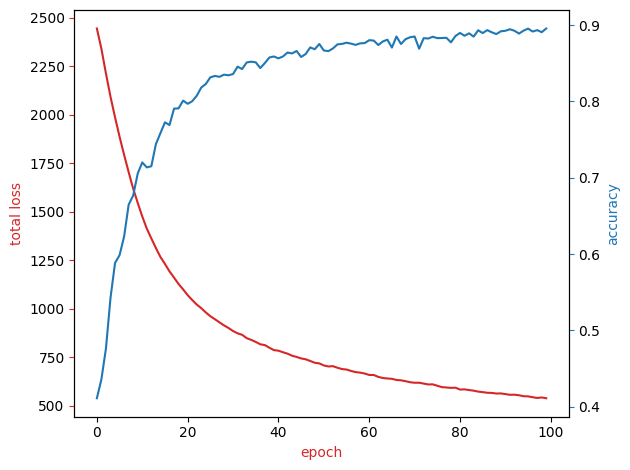

In [66]:
plot(cum_loss_list,acc_epoch)

In [67]:
evaluate(test_dataloader, model_)

0.8825

In [97]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model_(text)
        return ag_news_label[output.argmax(1).item() + 1]

In [98]:
def classify_news_article(article_text):
    """
    Classify a news article and display the result in a formatted markdown box.
    Uses your existing predict() function.

    Args:
        article_text (str): The news article text to classify

    Returns:
        str: The predicted category
    """
    # Use your existing predict function
    result = predict(article_text, text_pipeline)

    # Create formatted markdown content
    markdown_content = f'''
    <div style="background-color: #f0f0f0; border-left: 4px solid #4CAF50; padding: 15px; margin: 10px 0; border-radius: 5px;">
        <h3 style="color: #333; margin-top: 0;">📰 News Article Classification</h3>
        <div style="background-color: white; padding: 10px; border-radius: 3px; margin: 10px 0;">
            <p style="font-style: italic; margin: 0;"><strong>Article:</strong> {article_text}</p>
        </div>
        <h4 style="color: #4CAF50; margin-bottom: 0;">🏷️ Predicted Category: <span style="background-color: #4CAF50; color: white; padding: 2px 8px; border-radius: 3px;">{result}</span></h4>
    </div>
    '''

    # Display the result
    md(markdown_content)

    return result

In [99]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

classify_news_article(article)

'Sports'

In [100]:
article="""Carlos Sainz says he is committed to Williams amid renewed uncertainty in the F1 driver market following speculation Max Verstappen could leave Red Bull.
Ferrari's signing of Lewis Hamilton left Sainz without a seat for 2025, before he eventually moved to Williams after being overlooked by Mercedes and Red Bull.
Mercedes boss Toto Wolff has confirmed he is in talks to sign Verstappen, with the prospective move having the potential to trigger a reshuffle on the grid. """

classify_news_article(article)

'Sports'

In [104]:
article1="""Scientists have announced a major breakthrough in fusion energy, achieving sustained net energy gain in a laboratory setting. This development could pave the way for a new era of clean, limitless power, significantly impacting global energy strategies and climate change mitigation efforts."""
classify_news_article(article1)

'Business'

In [103]:
article2="""The global stock markets experienced a volatile trading day, with major indices fluctuating significantly due to ongoing inflation concerns and unexpected interest rate announcements from central banks. Analysts are closely watching for signs of economic stabilization in the coming weeks."""
classify_news_article(article2)

'Business'

In [102]:
article3="""The national basketball team secured a thrilling victory in the championship final, winning by a single point in the last seconds of overtime. The win marks their first title in over a decade, sparking widespread celebrations among fans across the country."""
classify_news_article(article3)

'Sports'